<a href="https://colab.research.google.com/github/MishraShardendu22/CNN-Deep-Learning-Project-Implementation/blob/main/CNN_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
!pip install tensorflow

In [33]:
import tensorflow as tf
import os
from google.colab import drive


if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print('Google Drive is already mounted.')

path = '/content/drive/MyDrive/DisasterModel'

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

print(f"Using dataset path: {path}")
print(f"Using image size: {IMG_SIZE}")
print(f"Using batch size: {BATCH_SIZE}")

Google Drive is already mounted.
Using dataset path: /content/drive/MyDrive/DisasterModel
Using image size: (128, 128)
Using batch size: 32


In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Instantiate EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Instantiate ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=0.00001
)

print("EarlyStopping and ReduceLROnPlateau callbacks created.")

EarlyStopping and ReduceLROnPlateau callbacks created.


In [35]:
from tensorflow.keras.utils import image_dataset_from_directory

# Define the paths for the training and validation data subdirectories
train_data_path = os.path.join(path, 'train')
val_data_path = os.path.join(path, 'validation')

print(f"Training data path: {train_data_path}")
print(f"Validation data path: {val_data_path}")

# Re-create train_ds pointing to the 'train' subdirectory
train_ds = image_dataset_from_directory(
    train_data_path,
    labels='inferred',
    label_mode='int',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Re-create val_ds pointing to the 'validation' subdirectory
val_ds = image_dataset_from_directory(
    val_data_path,
    labels='inferred',
    label_mode='int',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Datasets reloaded from specific 'train' and 'validation' subdirectories.")

# Get class names from the actual training data path directories
class_names = sorted(os.listdir(train_data_path))
print(f"New class names: {class_names}")

# Reapply normalization layer
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
print("Normalization re-applied to both datasets.")

# Reapply data augmentation layers to the new train_ds
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
print("Data augmentation layers re-applied to train_ds.")

Training data path: /content/drive/MyDrive/DisasterModel/train
Validation data path: /content/drive/MyDrive/DisasterModel/validation
Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Datasets reloaded from specific 'train' and 'validation' subdirectories.
New class names: ['cyclone', 'earthquake', 'flood', 'wildfire']
Normalization re-applied to both datasets.
Data augmentation layers re-applied to train_ds.


Reconfigured Training dataset class distribution:
  cyclone: 400
  earthquake: 400
  flood: 400
  wildfire: 400

Reconfigured Validation dataset class distribution:
  cyclone: 100
  earthquake: 100
  flood: 100
  wildfire: 100


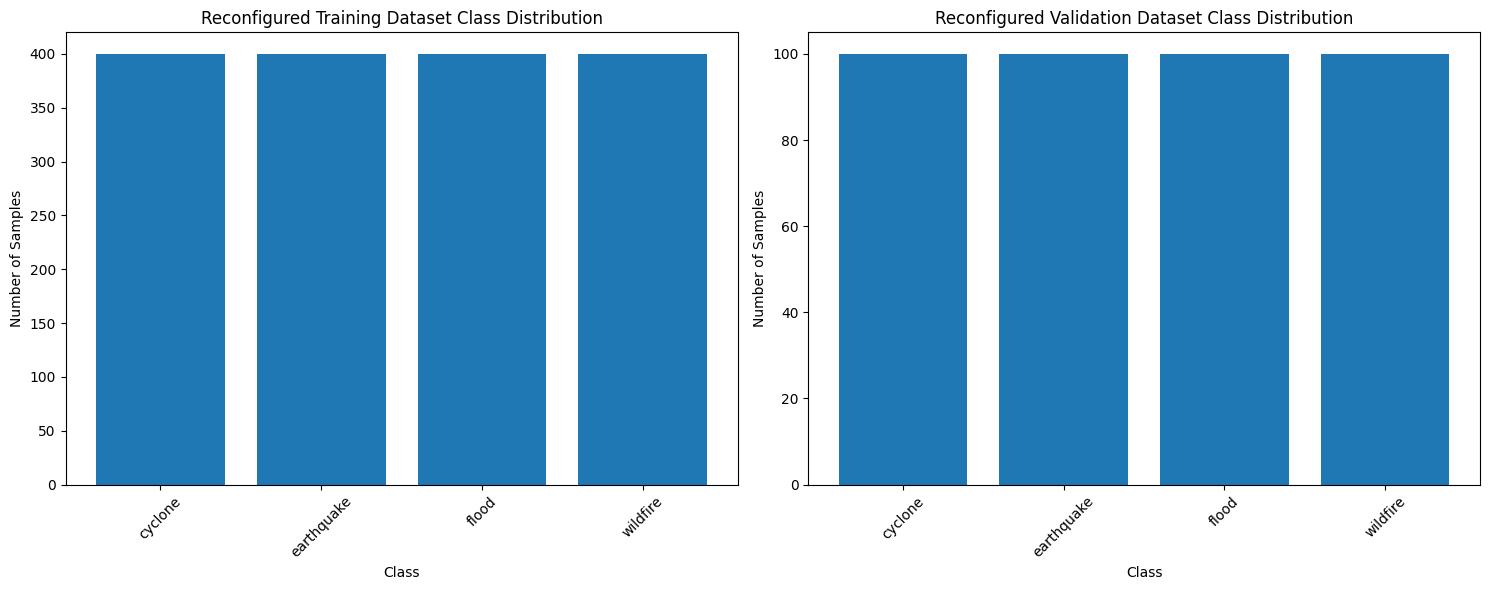

Class distribution plots generated for reconfigured training and validation datasets.


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Extract labels from the reconfigured train_ds
new_train_labels = []
for _, labels in train_ds.unbatch():
    new_train_labels.append(labels.numpy())
new_train_labels = np.array(new_train_labels)

# Extract labels from the reconfigured val_ds
new_val_labels = []
for _, labels in val_ds.unbatch():
    new_val_labels.append(labels.numpy())
new_val_labels = np.array(new_val_labels)

# Count occurrences for new_train_ds and print
new_train_distribution = np.bincount(new_train_labels)
print("Reconfigured Training dataset class distribution:")
for i, count in enumerate(new_train_distribution):
    print(f"  {class_names[i]}: {count}")

# Count occurrences for new_val_ds and print
new_val_distribution = np.bincount(new_val_labels)
print("\nReconfigured Validation dataset class distribution:")
for i, count in enumerate(new_val_distribution):
    print(f"  {class_names[i]}: {count}")

# Create subplots for training and validation distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot training dataset class distribution
axes[0].bar(class_names, new_train_distribution)
axes[0].set_title('Reconfigured Training Dataset Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Plot validation dataset class distribution
axes[1].bar(class_names, new_val_distribution)
axes[1].set_title('Reconfigured Validation Dataset Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Class distribution plots generated for reconfigured training and validation datasets.")

In [37]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_augmented = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)
print("Model recompiled and retraining initiated with data augmentation and callbacks.")

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 514ms/step - accuracy: 0.8626 - loss: 0.3960 - val_accuracy: 0.8525 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.8543 - loss: 0.3828 - val_accuracy: 0.8500 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 488ms/step - accuracy: 0.8756 - loss: 0.3318 - val_accuracy: 0.8000 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8890 - loss: 0.3008
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - accuracy: 0.8890 - loss: 0.3010 - val_accuracy: 0.8550 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.9103 - loss: 0.2492 - val_accuracy: 0.8525 - val_loss: 0.4924 - learning_rate: 2.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.9036 - loss:

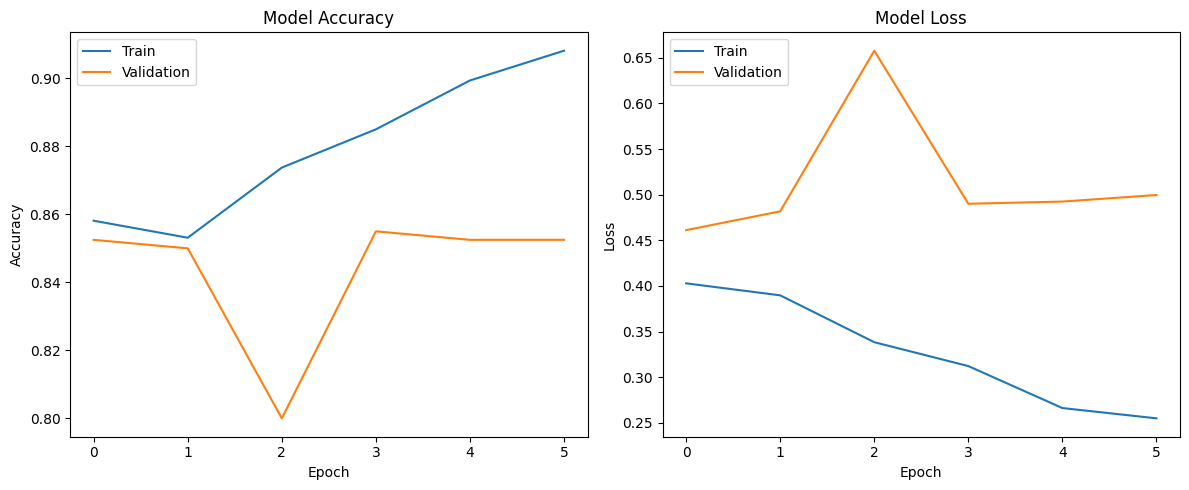

Training history plots generated.


In [38]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

print("Training history plots generated.")